# Procure-to-Pay Analysis: A Proces Mining Approach

This repository aims to apply process mining approach to a procure-to-pay process. The process contains the following (adjusted) activities: 
- <b>Document date</b>: 
- <b>Invoice received</b>: The date the invoice is received from the Vendor
- <b>1st approval</b>: The date the invoice was first approved
- <b>2nd approval</b>: The date the invoice was approved by the 2nd approver
- <b>Posting date</b>: When the invoice was posted to the system
- <b>Payment performed</b>: When the payment was made to the Vendor

Other information contained in the event log includes the following
* <b>Entity</b>: all cases relates to one entity - 4097 
* <b>Account</b>: The unique identifier of the Vendor. We will be using this rather than the Vendor Name
* <b>Comment</b>: If the process was a reversal of an existing process
* <b>Gross Amount</b>: The gross amount for each case

The event log consists of 1696 cases between January 2015 and August 2017. Although, majority of the cases happened in 2017.

# Data Preparation

Here, I aim to explore the event log to ensure that it is suitable for process mining analysis. The following activities were carried out:
1. Rename the columns to make them easier to reference and understand
2. Melt the data to get the dataframe into the required format for process mining
3. Remove rows with missing times. This is because from the dataset received, those activities do not occur in that particular purchase order.
4. Sort the event log using the unique identifier (<b>Document No.</b>) and Date column. This is to arrange each Purchase document accoring to how the activities were performed (by date)
5. Extracted those cases which have been completed. I assumed that the process is complete when the payment has been made (i.e., the last activity is <b>Payment performed</b>).
6. Generated the duration for each activity in a purchase order.
7. PowerBI Data format. One of the weakness in PowerBI is that where two activities are performed on the same date, it sorts these activities alphabetically. For example, if the <b>posting date</b> and <b>payment performed</b> activities were performed on the same day, the payment performed activity would come first before posting date even though in jupyter notebook, posting date comes first. To avoid this, I  included an <b>Event_ID</b> column so that to sort the activities properly in Powerbi.

In [1]:
import pandas as pd
import graphviz

In [2]:
df = pd.read_excel("P2P Data Extract Random AG.xlsx")
df.head(1)

,Entity,Account,Document Date,Document No.,Invoice Receival = Doc Arrival Date,Posting Date = Invoice approved,Invoice approved = 1st approval,Invoice approved = 2nd approval,Compensation = Payment performed,Comment,Gross Amount in house currency,Vendor Name
0,4097,402133,2017-02-07,3200004050,2017-02-13 06:40:00,2017-05-03,2017-02-17,NaT,NaT,Reversal,22059.94,Sunlight Microsystems


### Data Transformation

- Separate the reversal cases - when there is a reversal, a new case is created and then the opposite amount is reversed. Can this be done without creating a new case? Some cases that were reversed, there was no corresponding payment performed.
- How many start/end activities? Done
- How long does it take for from the invoice received to payment performed? Done
- When do we need to get a 2nd approval? i.e., is it relating to any particular amount or vendor? - The second approval started in February 2017
- When do we need to get a 1st approval? 
- How many cases without an approval? Done Is it based on amount? or Vendor?
- Are there payments without approvals? Yes. Done 694 payments amounting to 1,586,935 have been made without approval - Findings/Observations
- There should be an amount limit where a 1st approver is needed and a higher amount limit where a 2nd approver is needed before payment is made as it is an indicator of Fraud. - Improvements
- All 402 payments to Vendor xxx have been made without approval. They are all recurring payments amounting to xxx - Findings
- Are there delays between approvals? i.e., how long between 1st approval and 2nd approval? If the difference are negative, then there is a possibility that there is a 2nd approval first before a 1st approval. Done
- Do we have to keep approving for recurring payments? Some amounts looks like a negative amount. and are occuring monthly.
- How do we know recurring payments? - Vendor Page
- Can we have a 2nd approval without a first approval? No
- How long between first and second approval? Done
- How long between first approval and posting? No need
- Payments without posting? Done
- How long between posting and payment? Done - Findings
- The positive numbers are either reversals or returns. - Observations
- For those cases without approval, is it a recurring payment? If yes, have the first payment been approved?
- Reversals should be done on the same case so that we can track the reversal - Observation/Improvements
- Users were not given, as such we can't know who performs this processes, check for segregation of duties and handover of work from one user to another - Limitation
- Six payments were made on a Saturday and 1 on a Sunday all relating to Vendor xxxx - Findings/Observations
- Hard to understand when a 1st or 2nd approval is needed. 2nd approval started in April 2017 - Observations
- Process Deviations - How many process did not start with document received?

In [3]:
df.columns

Index(['Entity', 'Account', 'Document Date', 'Document No.',
       'Invoice Receival = Doc Arrival Date ',
       'Posting Date = Invoice approved', 'Invoice approved = 1st approval',
       'Invoice approved = 2nd approval', 'Compensation = Payment performed',
       'Comment', 'Gross Amount in house currency', 'Vendor Name'],
      dtype='object')

In [4]:
df.rename(columns={'Invoice Receival = Doc Arrival Date ': 'Invoice Received', 
                   'Posting Date = Invoice approved': 'Posting Date', 
                   'Invoice approved = 1st approval': '1st approval', 
                   'Invoice approved = 2nd approval': '2nd approval', 
                   'Compensation = Payment performed': 'Payment performed', 
                   'Gross Amount in house currency': 'Gross Amount'}, inplace=True)
df.head(2)

,Entity,Account,Document Date,Document No.,Invoice Received,Posting Date,1st approval,2nd approval,Payment performed,Comment,Gross Amount,Vendor Name
0,4097,402133,2017-02-07,3200004050,2017-02-13 06:40:00,2017-05-03,2017-02-17,NaT,NaT,Reversal,22059.94,Sunlight Microsystems
1,4097,402225,2017-05-04,3200004417,2017-05-11 07:47:00,2017-05-17,2017-05-16,NaT,2017-05-17,Reversal,16026.44,Timber Security


In [5]:
df.columns

Index(['Entity', 'Account', 'Document Date', 'Document No.',
       'Invoice Received', 'Posting Date', '1st approval', '2nd approval',
       'Payment performed', 'Comment', 'Gross Amount', 'Vendor Name'],
      dtype='object')

In [6]:
df = pd.melt(df, id_vars=['Entity', 'Account', 'Document No.',
       'Comment', 'Gross Amount', 'Vendor Name'], var_name='Events', value_name='Date')
df

,Entity,Account,Document No.,Comment,Gross Amount,Vendor Name,Events,Date
0,4097,402133,3200004050,Reversal,22059.94,Sunlight Microsystems,Document Date,2017-02-07
1,4097,402225,3200004417,Reversal,16026.44,Timber Security,Document Date,2017-05-04
2,4097,406913,3200003800,Reversal,10567.20,Life Corp,Document Date,2017-03-30
3,4097,404791,3100000253,NaN,7020.00,Prime Aviation,Document Date,2017-02-15
4,4097,408426,3100000223,Reversal,5850.04,Moon Co.,Document Date,2017-04-19
...,...,...,...,...,...,...,...,...
10171,4097,407301,3200004067,NaN,-131895.70,Aces,Payment performed,2017-05-08
10172,4097,402893,3200002874,NaN,-156035.29,Woodbank,Payment performed,2017-04-07
10173,4097,402893,3200003905,NaN,-162435.61,Woodbank,Payment performed,2017-05-08
10174,4097,402893,3200004653,NaN,-162435.61,Woodbank,Payment performed,2017-06-08


In [7]:
df.isnull().sum()

Entity              0
Account             0
Document No.        0
Comment         10014
Gross Amount        0
Vendor Name         0
Events              0
Date             2415
dtype: int64

In [8]:
nul_dates = pd.isna(df['Date'])
df[nul_dates]

,Entity,Account,Document No.,Comment,Gross Amount,Vendor Name,Events,Date
1702,4097,408357,3100000199,NaN,5000.00,Apachestones,Invoice Received,NaT
1740,4097,406372,3200003629,Reversal,73.95,Turtle Technologies,Invoice Received,NaT
1760,4097,406853,3200002886,NaN,-7.14,Mountelligence,Invoice Received,NaT
1761,4097,406853,3200002925,NaN,-7.14,Mountelligence,Invoice Received,NaT
1762,4097,406853,3200002893,NaN,-7.14,Mountelligence,Invoice Received,NaT
...,...,...,...,...,...,...,...,...
9889,4097,402103,3200004944,NaN,-1560.09,Radiantelligence,Payment performed,NaT
9966,4097,402103,3200004137,NaN,-2219.72,Radiantelligence,Payment performed,NaT
10023,4097,402103,3200004942,NaN,-3899.84,Radiantelligence,Payment performed,NaT
10140,4097,402133,3200003683,NaN,-21905.01,Sunlight Microsystems,Payment performed,NaT


In [9]:
df = df.dropna(subset=['Date'])
df = df.sort_values(by=['Document No.', 'Date'], ascending=True).reset_index(drop=True)
df

,Entity,Account,Document No.,Comment,Gross Amount,Vendor Name,Events,Date
0,4097,403971,3100000174,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00
1,4097,403971,3100000174,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00
2,4097,403971,3100000174,Reversal,24.28,Squidware,Posting Date,2017-04-04 00:00:00
3,4097,403971,3100000174,Reversal,24.28,Squidware,Payment performed,2017-04-04 00:00:00
4,4097,401873,3100000184,NaN,249.01,Rabbit Brews,Document Date,2017-03-15 00:00:00
...,...,...,...,...,...,...,...,...
7756,4097,404990,3300005153,Reversal,119.60,Luckyair,1st approval,2017-04-07 00:00:00
7757,4097,404990,3300005153,Reversal,119.60,Luckyair,2nd approval,2017-04-07 00:00:00
7758,4097,404990,3300005153,Reversal,119.60,Luckyair,Invoice Received,2017-05-26 11:42:00
7759,4097,404990,3300005153,Reversal,119.60,Luckyair,Posting Date,2017-06-19 00:00:00


In [10]:
df['Events'].unique()

array(['Document Date', 'Invoice Received', 'Posting Date',
       'Payment performed', '1st approval', '2nd approval'], dtype=object)

In [11]:
def func(x):
    # Get the last valid index (last activity per case)
    if x.last_valid_index() is None:
        return np.nan
    else:
        return x[x.last_valid_index()]

def activity_list(df, case_id, activities):
    # Get the last and first activity for each case
    activities_list = df.copy()
    activities_list['Count'] = activities_list.groupby(case_id).cumcount()+1
    activities_list = activities_list.pivot(index=case_id, columns='Count', values=activities)

    activities_list['Last Activity'] = activities_list.apply(func, axis=1)
    activities_list['First Activity'] = activities_list[1]
    return activities_list

In [12]:
df_activities = activity_list(df,'Document No.','Events')
df_activities

Count,1,2,3,4,5,6,Last Activity,First Activity
Document No.,,,,,,,,
3100000174,Document Date,Invoice Received,Posting Date,Payment performed,NaN,NaN,Payment performed,Document Date
3100000184,Document Date,Invoice Received,1st approval,Posting Date,Payment performed,NaN,Payment performed,Document Date
3100000187,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date
3100000188,Document Date,Invoice Received,Posting Date,Payment performed,1st approval,NaN,1st approval,Document Date
3100000189,Document Date,Invoice Received,Posting Date,Payment performed,NaN,NaN,Payment performed,Document Date
...,...,...,...,...,...,...,...,...
3200005578,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date
3200005579,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date
3200005580,Document Date,Invoice Received,1st approval,Posting Date,Payment performed,NaN,Payment performed,Document Date


In [13]:
df_activities['Last Activity'].value_counts()

Payment performed    1484
1st approval          117
Posting Date           79
2nd approval           14
Invoice Received        2
Name: Last Activity, dtype: int64

In [14]:
df_activities['First Activity'].value_counts()

Document Date       1682
Invoice Received       7
1st approval           4
Posting Date           3
Name: First Activity, dtype: int64

In [15]:
df_activities['new_c'] = df_activities.apply(lambda x: "Yes" if (x['Last Activity']=='Payment performed') else "No", axis=1)
df_activities

Count,1,2,3,4,5,6,Last Activity,First Activity,new_c
Document No.,,,,,,,,,
3100000174,Document Date,Invoice Received,Posting Date,Payment performed,NaN,NaN,Payment performed,Document Date,Yes
3100000184,Document Date,Invoice Received,1st approval,Posting Date,Payment performed,NaN,Payment performed,Document Date,Yes
3100000187,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date,Yes
3100000188,Document Date,Invoice Received,Posting Date,Payment performed,1st approval,NaN,1st approval,Document Date,No
3100000189,Document Date,Invoice Received,Posting Date,Payment performed,NaN,NaN,Payment performed,Document Date,Yes
...,...,...,...,...,...,...,...,...,...
3200005578,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date,Yes
3200005579,Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed,Payment performed,Document Date,Yes
3200005580,Document Date,Invoice Received,1st approval,Posting Date,Payment performed,NaN,Payment performed,Document Date,Yes


In [16]:
df_activities.reset_index(inplace=True)

In [17]:
df_activ_2 = df_activities.copy()
df_activ_2 = df_activ_2[df_activ_2['new_c'] == 'Yes']
df_activ_2 = df_activ_2[['Document No.']]
df_activ_2

Count,Document No.
0,3100000174
1,3100000184
2,3100000187
4,3100000189
6,3100000195
...,...
1691,3200005578
1692,3200005579
1693,3200005580
1694,3200005616


In [18]:
df = df_activ_2.merge(df, on='Document No.')
df

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date
0,3100000174,4097,403971,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00
1,3100000174,4097,403971,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00
2,3100000174,4097,403971,Reversal,24.28,Squidware,Posting Date,2017-04-04 00:00:00
3,3100000174,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04 00:00:00
4,3100000184,4097,401873,NaN,249.01,Rabbit Brews,Document Date,2017-03-15 00:00:00
...,...,...,...,...,...,...,...,...
6830,3300005153,4097,404990,Reversal,119.60,Luckyair,1st approval,2017-04-07 00:00:00
6831,3300005153,4097,404990,Reversal,119.60,Luckyair,2nd approval,2017-04-07 00:00:00
6832,3300005153,4097,404990,Reversal,119.60,Luckyair,Invoice Received,2017-05-26 11:42:00
6833,3300005153,4097,404990,Reversal,119.60,Luckyair,Posting Date,2017-06-19 00:00:00


In [19]:
df['Duration'] = df.groupby(['Document No.'])['Date'].diff().dt.days
df['Duration'] = df['Duration'].fillna(0)
df

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration
0,3100000174,4097,403971,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00,0.0
1,3100000174,4097,403971,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00,3.0
2,3100000174,4097,403971,Reversal,24.28,Squidware,Posting Date,2017-04-04 00:00:00,4.0
3,3100000174,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04 00:00:00,0.0
4,3100000184,4097,401873,NaN,249.01,Rabbit Brews,Document Date,2017-03-15 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...
6830,3300005153,4097,404990,Reversal,119.60,Luckyair,1st approval,2017-04-07 00:00:00,65.0
6831,3300005153,4097,404990,Reversal,119.60,Luckyair,2nd approval,2017-04-07 00:00:00,0.0
6832,3300005153,4097,404990,Reversal,119.60,Luckyair,Invoice Received,2017-05-26 11:42:00,49.0
6833,3300005153,4097,404990,Reversal,119.60,Luckyair,Posting Date,2017-06-19 00:00:00,23.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6835 entries, 0 to 6834
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Document No.  6835 non-null   int64         
 1   Entity        6835 non-null   int64         
 2   Account       6835 non-null   int64         
 3   Comment       107 non-null    object        
 4   Gross Amount  6835 non-null   float64       
 5   Vendor Name   6835 non-null   object        
 6   Events        6835 non-null   object        
 7   Date          6835 non-null   datetime64[ns]
 8   Duration      6835 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 534.0+ KB


In [21]:
df[df['Comment'] == 'Reversal']['Document No.'].nunique()

24

In [22]:
df['Document No.'].nunique()

1484

In [23]:
df['Event_ID'] = df.groupby(['Document No.']).cumcount()+1
df

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID
0,3100000174,4097,403971,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00,0.0,1
1,3100000174,4097,403971,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00,3.0,2
2,3100000174,4097,403971,Reversal,24.28,Squidware,Posting Date,2017-04-04 00:00:00,4.0,3
3,3100000174,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04 00:00:00,0.0,4
4,3100000184,4097,401873,NaN,249.01,Rabbit Brews,Document Date,2017-03-15 00:00:00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6830,3300005153,4097,404990,Reversal,119.60,Luckyair,1st approval,2017-04-07 00:00:00,65.0,2
6831,3300005153,4097,404990,Reversal,119.60,Luckyair,2nd approval,2017-04-07 00:00:00,0.0,3
6832,3300005153,4097,404990,Reversal,119.60,Luckyair,Invoice Received,2017-05-26 11:42:00,49.0,4
6833,3300005153,4097,404990,Reversal,119.60,Luckyair,Posting Date,2017-06-19 00:00:00,23.0,5


In [24]:
# df.to_csv('P2P_Final.csv', index=False)

# Process Discovery

### Variant anaysis

The variant analysis shows how frequently a particular procurement process is followed. It is important to emphasise that even if there are more than one process, only one process is the correct one. There are various things that can happen in a procurement process. For example, there might be cases where an approval is not needed, or where only one approval is needed ot both approvals are needed. All these are various processes that can be followed.

From the below, there are a total of 26 variants. The first 4 variants already account for about 83% of all completed procurements. Meanwhile 7 variants occur only once. A closer look at these variants shows that before a payment is performed, the posting date activity is done. More analysis will be done when it is visualised in PowerBI.

In [25]:
# Variants
def variant_analysis(df,case_id, activities):
    # Get the process variants
    variants = df.copy()
    variants['Count'] = variants.groupby(case_id).cumcount()+1
    variants = variants.pivot(index=case_id, columns='Count', values=activities)
    variants_col = variants.columns
    
    # Fill the empty cells (NaN) with 'X'
    variants = variants.fillna('X')
    variants = variants.astype('str')
    
    # Get the trace of each case by joining all the columns together, separated by a comma (,) and replace ',X' with nothing to delete the ',X'
    variants['Trace'] = variants.apply(lambda x: ','.join(x),axis=1)
    variants['Trace'] = variants['Trace'].apply(lambda x: x.replace(',X',''))
    
    # Group the similar variants and get the count
    variants_sum = variants[['Trace',1]].groupby(['Trace'], as_index=False).count()
    variants_sum = variants_sum.sort_values(by=1, ascending=False).reset_index()
    del variants_sum['index']
    variants_sum = variants_sum.reset_index()
    variants_sum['index'] = variants_sum['index']+1
    variants_sum = variants_sum.rename(columns={'index':'Variants',1:'No of occurance'})
    return variants_sum

In [26]:
variants = variant_analysis(df, 'Document No.', 'Events')
variants

Count,Variants,Trace,No of occurance
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405
1,2,"Document Date,Invoice Received,1st approval,Po...",343
2,3,"Document Date,Posting Date,Payment performed",261
3,4,"Document Date,Invoice Received,1st approval,2n...",230
4,5,"Document Date,Invoice Received,1st approval,Po...",53
5,6,"Document Date,Invoice Received,Posting Date,1s...",39
6,7,"Document Date,1st approval,2nd approval,Invoic...",36
7,8,"Document Date,1st approval,Invoice Received,Po...",25
8,9,"Document Date,Posting Date,Invoice Received,Pa...",25
9,10,"Document Date,Invoice Received,Posting Date,1s...",25


In [27]:
list(variants['Trace'][:5])

['Document Date,Invoice Received,Posting Date,Payment performed',
 'Document Date,Invoice Received,1st approval,Posting Date,Payment performed',
 'Document Date,Posting Date,Payment performed',
 'Document Date,Invoice Received,1st approval,2nd approval,Posting Date,Payment performed',
 'Document Date,Invoice Received,1st approval,Posting Date,2nd approval,Payment performed']

In [28]:
def variant_analysis_df(df,case_id, activities):
    # Get the process variants
    variants_df = df.copy()
    variants_df['Count'] = variants_df.groupby(case_id).cumcount()+1
    variants_df = variants_df.pivot(index=case_id, columns='Count', values=activities)
    variants_df_col = variants_df.columns
    
    # Fill the empty cells (NaN) with 'X'
    variants_df = variants_df.fillna('X')
    variants_df = variants_df.astype('str')
    
    # Get the trace of each case by joining all the columns together, separated by a comma (,) and replace ',X' with nothing to delete the ',X'
    variants_df['Trace'] = variants_df.apply(lambda x: ','.join(x),axis=1)
    variants_df['Trace'] = variants_df['Trace'].apply(lambda x: x.replace(',X',''))
    
    # Merge with the variants_analysis df
    variants = variant_analysis(df, case_id, activities)
    variants_df = variants.merge(pd.DataFrame(variants_df).reset_index(), on='Trace')
    variants_df = variants_df.drop(variants_df_col, axis=1)
    return variants_df

In [29]:
distinct_df = variant_analysis_df(df, 'Document No.', 'Events')
distinct_df

Count,Variants,Trace,No of occurance,Document No.
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000174
1,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000189
2,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000195
3,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000215
4,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000216
...,...,...,...,...
1479,22,"Document Date,1st approval,Posting Date,Invoic...",1,3200005320
1480,23,"Invoice Received,1st approval,Document Date,Po...",1,3100000243
1481,24,"1st approval,Document Date,Invoice Received,2n...",1,3200004749
1482,25,"Invoice Received,Document Date,1st approval,Po...",1,3200004288


In [30]:
distinct_df['Variants'].value_counts()

1     405
2     343
3     261
4     230
5      53
6      39
7      36
8      25
9      25
10     25
11     12
12      4
13      4
16      3
14      3
15      3
17      2
18      2
19      2
20      1
21      1
22      1
23      1
24      1
25      1
26      1
Name: Variants, dtype: int64

### Process Graph
After looking at the variants, I proceeded to draw the Process graph. The process graph shows how the activity flows from the start of a procurement process to the end. To ensure I draw a process graph that can atleaset be understandable, I decided to get the start activities (which will be shown at the top) and the end activities (which will be shown at the bottom). I did not filter for any particular variant as this will be visualised easily in PowerBI.

From the below, there are four different start activities and one end activity. This is expected as I filtered for cases which ends only with Payment Performed activity.

In [31]:
# Start Activities
def start_activities(df, case_id, activities):
    activities_list = activity_list(df, case_id, activities)
    start_act = activities_list.groupby(['First Activity']).size()
    start_act = start_act.to_frame(name='Count').reset_index()
    start_act['Start'] = 'Start'
    start_act = start_act[['Start','First Activity','Count']]
    start_act = start_act.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return start_act

In [32]:
# End Activities
def end_activities(df, case_id, activities):
    activities_list = activity_list(df, case_id, activities)
    end_act = activities_list.groupby(['Last Activity']).size()
    end_act = end_act.to_frame(name='Count').reset_index()
    end_act['End'] = 'End'
    end_act = end_act[['End','Last Activity','Count']]
    end_act = end_act.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return end_act

In [33]:
# Process details
def process_details(df, case_id, timestamp, activities):
    # Get the dataframe
    df_1 = df.copy()
    df_1 = df_1[[case_id, timestamp, activities]]
    df_1 = df_1.merge(df_1.shift(-1), left_index=True, right_index=True, suffixes=('', '_2'))
    df_1 = df_1[df_1[case_id] == df_1[case_id+'_2']]
    df_1 = df_1[[case_id, activities, activities+'_2']]
    df_1 = df_1.groupby([activities,activities+'_2'], sort=False).size()
    df_1 = df_1.to_frame(name='Count').reset_index()
    return df_1

In [34]:
# Graph count
def graph_count(df, activities):
    graph_count = df.copy()
    graph_count = graph_count[activities].value_counts().to_frame().reset_index().rename(columns={'index':activities, activities:'Count'})
    return graph_count

In [35]:
df.head(2)

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID
0,3100000174,4097,403971,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00,0.0,1
1,3100000174,4097,403971,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00,3.0,2


In [36]:
start_act = start_activities(df, 'Document No.', 'Events')
start_act

,Start,First Activity,Count
0,Start,Document Date,1470
1,Start,Invoice Received,7
2,Start,1st approval,4
3,Start,Posting Date,3


In [37]:
end_act = end_activities(df, 'Document No.', 'Events')
end_act

,End,Last Activity,Count
0,End,Payment performed,1484


In [38]:
pro_det = process_details(df, 'Document No.', 'Date', 'Events')
pro_det

,Events,Events_2,Count
0,Document Date,Invoice Received,1099
1,Invoice Received,Posting Date,536
2,Posting Date,Payment performed,1327
3,Invoice Received,1st approval,630
4,1st approval,Posting Date,399
5,1st approval,2nd approval,298
6,2nd approval,Posting Date,253
7,Document Date,Posting Date,293
8,Posting Date,2nd approval,57
9,2nd approval,Payment performed,82


In [39]:
gra_coun = graph_count(df, 'Events')
gra_coun

,Events,Count
0,Document Date,1484
1,Posting Date,1484
2,Payment performed,1484
3,Invoice Received,1220
4,1st approval,787
5,2nd approval,376


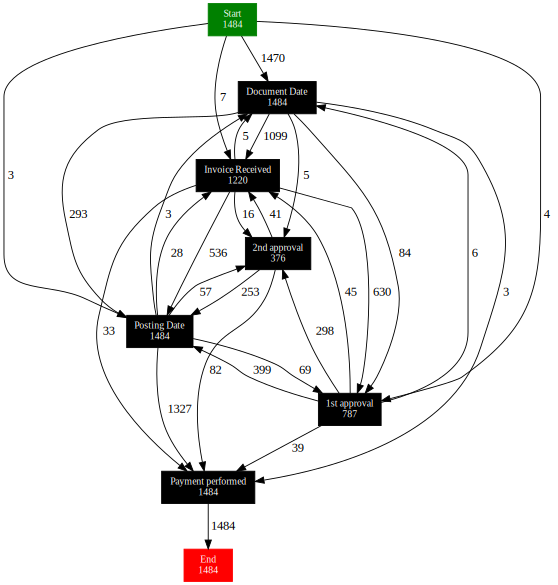

In [40]:
g = graphviz.Digraph('neato', format='png', encoding='utf8',
            filename='2_way_match', node_attr={'color': 'black', 'style': 'filled', 'fontcolor':'white','fontsize':'11'}, 
                     edge_attr={'weight': '1'})
g.attr('node', shape='box')
g.attr(rankdir='TB')
# h.attr(nodesep='0.1')
g.attr(size='7.75,10.25')

# max_node = 5
# max_case_id = sortnewtimetest['Count'].max()

# create all the possible nodes first
# you can modify the `label` 

for index, row in start_act.iterrows():
    g.node(row['Start'],label=row['Start'] + '\n '+ str(start_act[start_act['Start'] == row['Start']]['Count'].sum()), _attributes={'color':'green', 'fontcolor':'white'})
#     , _attributes={'color':'green', 'fontcolor':'white'}
    g.node(row['First Activity'],label=row['First Activity'] + '\n '+ str(start_act[start_act['First Activity'] == row['First Activity']]['Count'].sum()))

for index, row in start_act.iterrows():
    starrt, firstact, count = [str(i) for i in row]
    g.edge(str(row["Start"]), str(row["First Activity"]), label="  " + count)
# , penwidth=str(int(row["Weight"])/max_case_id*max_node)
######################################################

for index, row in pro_det.iterrows():
    g.node(row['Events'],label=row['Events'] + '\n '+ str(gra_coun[gra_coun['Events'] == row['Events']]['Count'].sum()))
    g.node(row['Events_2'],label=row['Events_2'] + '\n '+ str(gra_coun[gra_coun['Events'] == row['Events_2']]['Count'].sum()))

for index, row in pro_det.iterrows():
    startevent, endevent, count = [str(i) for i in row]
    g.edge(str(row["Events"]), str(row["Events_2"]), label= "  " + count)
# , penwidth=str(int(row["Count"])/max_case_id*max_node)
######################################################

for index, row in end_act.iterrows():
    g.node(row['Last Activity'],label=row['Last Activity'] + '\n '+ str(gra_coun[gra_coun['Events'] == row['Last Activity']]['Count'].sum()))
    g.node(row['End'],label=row['End'] + '\n '+ str(end_act[end_act['End'] == row['End']]['Count'].sum()) , _attributes={'color':'red', 'fontcolor':'white'})
# ,  _attributes={'color':'red', 'fontcolor':'white'}
for index, row in end_act.iterrows():
    lastact, endact, count = [str(i) for i in row]
    g.edge(str(row["Last Activity"]), str(row["End"]), label= "  " + count)
# , penwidth=str(int(row["Weight"])/max_case_id*max_node)
######################################################

# g.view()
g

### Transition Matrix
Since we have been able to get the various events, and how they follow each other, we can the come up with a transition matrix to see how these activities transition from one to another and how frequently this happens.

From the below, we can see that <b>Payment performed</b> activity is not followed by any other activity i.e., that is the end of the process. However all other events can be done before Payment Performed. The most frequently occuring activity before <b>Payment performed</b> is the <b>Posting Date</b>. <b>Document Date</b> is mostly followed by <b>Invoice Received</b> and <b>Invoice Received</b> is mostly followed by <b>1st approval</b>. <b>2nd approval</b> is majorly done after <b>1st approval</b>.

Any other event can be performed before or after each other as shown below except <b>Posting Date</b> and <b>Payment performed</b>.

While this gives insight about how activities are performed in the process, the drawback of this matrix is that you can only see transitions but you can't see the full process as shown above. The dataset will be taken to PowerBI as it will be able to show the process flow that correspond to this matrix clearly and easily.

In [41]:
def process_details_test(df, case_id, timestamp, activities):
    # Get the dataframe
    df_1 = df.copy()
    df_1 = df_1[[case_id, timestamp, activities]]
    df_1 = df_1.merge(df_1.shift(-1), left_index=True, right_index=True, suffixes=('', '_2'))
    df_1 = df_1[df_1[case_id] == df_1[case_id+'_2']]
    return df_1

In [42]:
process_details_test(df, 'Document No.', 'Date', 'Events').pivot_table(index='Events', columns='Events_2', values='Document No.',aggfunc='count').fillna(0)

Events_2,1st approval,2nd approval,Document Date,Invoice Received,Payment performed,Posting Date
Events,,,,,,
1st approval,0.0,298.0,6.0,45.0,39.0,399.0
2nd approval,0.0,0.0,0.0,41.0,82.0,253.0
Document Date,84.0,5.0,0.0,1099.0,3.0,293.0
Invoice Received,630.0,16.0,5.0,0.0,33.0,536.0
Posting Date,69.0,57.0,3.0,28.0,1327.0,0.0


In [43]:
proc_det = process_details_test(df, 'Document No.', 'Date', 'Events')
proc_det

,Document No.,Date,Events,Document No._2,Date_2,Events_2
0,3100000174,2017-03-27 00:00:00,Document Date,3.100000e+09,2017-03-30 07:22:00,Invoice Received
1,3100000174,2017-03-30 07:22:00,Invoice Received,3.100000e+09,2017-04-04 00:00:00,Posting Date
2,3100000174,2017-04-04 00:00:00,Posting Date,3.100000e+09,2017-04-04 00:00:00,Payment performed
4,3100000184,2017-03-15 00:00:00,Document Date,3.100000e+09,2017-03-28 03:43:00,Invoice Received
5,3100000184,2017-03-28 03:43:00,Invoice Received,3.100000e+09,2017-04-03 00:00:00,1st approval
...,...,...,...,...,...,...
6829,3300005153,2017-02-01 00:00:00,Document Date,3.300005e+09,2017-04-07 00:00:00,1st approval
6830,3300005153,2017-04-07 00:00:00,1st approval,3.300005e+09,2017-04-07 00:00:00,2nd approval
6831,3300005153,2017-04-07 00:00:00,2nd approval,3.300005e+09,2017-05-26 11:42:00,Invoice Received
6832,3300005153,2017-05-26 11:42:00,Invoice Received,3.300005e+09,2017-06-19 00:00:00,Posting Date


In [44]:
# proc_det.to_csv('Process_details.csv', index=False)

# Peformance Analysis

Performance analysis has to do with timing. How long does it take for a process to be completed from start (Document Date) to finish (Payment Performed)? How long do activities in a process take to be completed?

As we have seen the process flow above, we would get more insights into the process when we look at the timing of these activities. Since we are only given one time for each activity, which I assume is when the activity was completed and moved to the next, we can derive the duration of each activity in a process and also the duration of each process from the begining (Document Date) to the end of the process (Payment Performed).

To get the duration of the activities between processes, the start time of a next activity within one case ID was considered to be an end time of a current one. 

### Case duration
From the below, we can see that majority of the cases were completed between 7 or 8 days.

In [45]:
def case_duration(df, case_id, dates):
    case_dur = df.copy()
    case_dur['Count'] = case_dur.groupby(case_id).cumcount()+1
    case_dur = case_dur.pivot(index=case_id, columns='Count', values=dates)
    case_dur_col = case_dur.columns
    case_dur['Max'] = case_dur.apply(max, axis=1)
    case_dur['Case_Duration_days'] = (case_dur['Max'] - case_dur[1]).dt.days
    case_dur = case_dur.drop(case_dur_col, axis=1)
    case_dur.reset_index(inplace=True)    
    return case_dur

In [46]:
case_duration(df,'Document No.','Date').drop('Max', axis=1)

Count,Document No.,Case_Duration_days
0,3100000174,8
1,3100000184,23
2,3100000187,73
3,3100000189,12
4,3100000195,12
...,...,...
1479,3200005578,23
1480,3200005579,33
1481,3200005580,33
1482,3200005616,13


In [47]:
distinct_df = distinct_df.merge(case_duration(df,'Document No.','Date').drop('Max', axis=1))
distinct_df

Count,Variants,Trace,No of occurance,Document No.,Case_Duration_days
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000174,8
1,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000189,12
2,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000195,12
3,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000215,27
4,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000216,40
...,...,...,...,...,...
1479,22,"Document Date,1st approval,Posting Date,Invoic...",1,3200005320,34
1480,23,"Invoice Received,1st approval,Document Date,Po...",1,3100000243,28
1481,24,"1st approval,Document Date,Invoice Received,2n...",1,3200004749,86
1482,25,"Invoice Received,Document Date,1st approval,Po...",1,3200004288,41


In [48]:
distinct_df['Case_Duration_days'].value_counts()

7      148
8      111
12      55
18      52
11      49
      ... 
119      1
91       1
451      1
477      1
86       1
Name: Case_Duration_days, Length: 129, dtype: int64

### Event duration

Here, we look at how much time is spent from one event to another. We focused on few transitions. Further analysis can be carried out on other events. We looked at the time between Invoice received to Payment (Days Payable Outstanding), time from posting to payment, 1st to 2nd approval, Invoice received to posting date. This dataset was then saved in an excel file to be used in PowerBI for data visualisation

In [49]:
event_duration = df.pivot(index='Document No.', columns='Events', values='Date').reset_index()
event_duration['Inv_Rec_Paymt'] = (event_duration['Payment performed']-event_duration['Invoice Received']).dt.days
event_duration['Post_Paymt'] = (event_duration['Payment performed']-event_duration['Posting Date']).dt.days
event_duration['1st_2nd_App'] = (event_duration['2nd approval']-event_duration['1st approval']).dt.days
event_duration['InvRec_PosDte'] = (event_duration['Posting Date']-event_duration['Invoice Received']).dt.days
event_duration

Events,Document No.,1st approval,2nd approval,Document Date,Invoice Received,Payment performed,Posting Date,Inv_Rec_Paymt,Post_Paymt,1st_2nd_App,InvRec_PosDte
0,3100000174,NaT,NaT,2017-03-27,2017-03-30 07:22:00,2017-04-04,2017-04-04,4.0,0,NaN,4.0
1,3100000184,2017-04-03,NaT,2017-03-15,2017-03-28 03:43:00,2017-04-07,2017-04-06,9.0,1,NaN,8.0
2,3100000187,2017-03-15,2017-03-17,2017-03-03,2017-03-06 07:48:00,2017-05-15,2017-04-11,69.0,34,2.0,35.0
3,3100000189,NaT,NaT,2017-04-06,2017-04-11 08:40:00,2017-04-18,2017-04-18,6.0,0,NaN,6.0
4,3100000195,NaT,NaT,2017-04-12,2017-04-20 10:38:00,2017-04-24,2017-04-24,3.0,0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...
1479,3200005578,2017-06-19,2017-06-29,2017-06-07,2017-06-13 07:20:00,2017-06-30,2017-06-30,16.0,0,10.0,16.0
1480,3200005579,2017-06-26,2017-06-29,2017-05-31,2017-06-21 09:53:00,2017-07-03,2017-06-30,11.0,3,3.0,8.0
1481,3200005580,2017-06-29,NaT,2017-05-31,2017-06-14 07:22:00,2017-07-03,2017-06-30,18.0,3,NaN,15.0
1482,3200005616,2017-07-03,NaT,2017-06-23,2017-06-24 07:08:00,2017-07-06,2017-06-30,11.0,6,NaN,5.0


In [50]:
# event_duration.to_csv('Event_duration.csv', index=False)

In [51]:
df

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID
0,3100000174,4097,403971,Reversal,24.28,Squidware,Document Date,2017-03-27 00:00:00,0.0,1
1,3100000174,4097,403971,Reversal,24.28,Squidware,Invoice Received,2017-03-30 07:22:00,3.0,2
2,3100000174,4097,403971,Reversal,24.28,Squidware,Posting Date,2017-04-04 00:00:00,4.0,3
3,3100000174,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04 00:00:00,0.0,4
4,3100000184,4097,401873,NaN,249.01,Rabbit Brews,Document Date,2017-03-15 00:00:00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6830,3300005153,4097,404990,Reversal,119.60,Luckyair,1st approval,2017-04-07 00:00:00,65.0,2
6831,3300005153,4097,404990,Reversal,119.60,Luckyair,2nd approval,2017-04-07 00:00:00,0.0,3
6832,3300005153,4097,404990,Reversal,119.60,Luckyair,Invoice Received,2017-05-26 11:42:00,49.0,4
6833,3300005153,4097,404990,Reversal,119.60,Luckyair,Posting Date,2017-06-19 00:00:00,23.0,5


In [52]:
df.groupby('Document No.').tail(1)

,Document No.,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID
3,3100000174,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04,0.0,4
8,3100000184,4097,401873,NaN,249.01,Rabbit Brews,Payment performed,2017-04-07,1.0,5
14,3100000187,4097,404999,NaN,66.90,Willow Arts,Payment performed,2017-05-15,34.0,6
18,3100000189,4097,407713,Reversal,42.36,Ravenfruit,Payment performed,2017-04-18,0.0,4
22,3100000195,4097,405361,Reversal,96.99,Lemonworks,Payment performed,2017-04-24,0.0,4
...,...,...,...,...,...,...,...,...,...,...
6812,3200005578,4097,402023,NaN,-1485.00,Wizardustries,Payment performed,2017-06-30,0.0,6
6818,3200005579,4097,408131,NaN,-799.83,Leopardworks,Payment performed,2017-07-03,3.0,6
6823,3200005580,4097,402845,NaN,-13.09,Globe Motors,Payment performed,2017-07-03,3.0,5
6828,3200005616,4097,401909,NaN,-287.68,Gale Networks,Payment performed,2017-07-06,3.0,5


In [53]:
distinct_df = distinct_df.merge(df.groupby('Document No.').tail(1), on='Document No.')
distinct_df

,Variants,Trace,No of occurance,Document No.,Case_Duration_days,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000174,8,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04,0.0,4
1,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000189,12,4097,407713,Reversal,42.36,Ravenfruit,Payment performed,2017-04-18,0.0,4
2,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000195,12,4097,405361,Reversal,96.99,Lemonworks,Payment performed,2017-04-24,0.0,4
3,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000215,27,4097,408462,Reversal,5801.25,Timbermedia,Payment performed,2017-05-08,0.0,4
4,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000216,40,4097,403496,Reversal,142.00,Globalworks,Payment performed,2017-05-10,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,22,"Document Date,1st approval,Posting Date,Invoic...",1,3200005320,34,4097,408458,NaN,-1749.30,Imaginavigations,Payment performed,2017-07-03,6.0,5
1480,23,"Invoice Received,1st approval,Document Date,Po...",1,3100000243,28,4097,408123,NaN,321.30,Betahut,Payment performed,2017-06-02,10.0,5
1481,24,"1st approval,Document Date,Invoice Received,2n...",1,3200004749,86,4097,404047,NaN,-155.24,Saturnetworks,Payment performed,2017-05-29,3.0,6
1482,25,"Invoice Received,Document Date,1st approval,Po...",1,3200004288,41,4097,406135,NaN,-918.36,Rosebite,Payment performed,2017-06-08,23.0,5


In [54]:
first_last = activity_list(df,'Document No.','Events').reset_index()
first_last = first_last[['Document No.','Last Activity','First Activity']]
first_last

Count,Document No.,Last Activity,First Activity
0,3100000174,Payment performed,Document Date
1,3100000184,Payment performed,Document Date
2,3100000187,Payment performed,Document Date
3,3100000189,Payment performed,Document Date
4,3100000195,Payment performed,Document Date
...,...,...,...
1479,3200005578,Payment performed,Document Date
1480,3200005579,Payment performed,Document Date
1481,3200005580,Payment performed,Document Date
1482,3200005616,Payment performed,Document Date


In [55]:
distinct_df = distinct_df.merge(first_last, on='Document No.')
distinct_df

,Variants,Trace,No of occurance,Document No.,Case_Duration_days,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID,Last Activity,First Activity
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000174,8,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04,0.0,4,Payment performed,Document Date
1,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000189,12,4097,407713,Reversal,42.36,Ravenfruit,Payment performed,2017-04-18,0.0,4,Payment performed,Document Date
2,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000195,12,4097,405361,Reversal,96.99,Lemonworks,Payment performed,2017-04-24,0.0,4,Payment performed,Document Date
3,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000215,27,4097,408462,Reversal,5801.25,Timbermedia,Payment performed,2017-05-08,0.0,4,Payment performed,Document Date
4,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000216,40,4097,403496,Reversal,142.00,Globalworks,Payment performed,2017-05-10,2.0,4,Payment performed,Document Date
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,22,"Document Date,1st approval,Posting Date,Invoic...",1,3200005320,34,4097,408458,NaN,-1749.30,Imaginavigations,Payment performed,2017-07-03,6.0,5,Payment performed,Document Date
1480,23,"Invoice Received,1st approval,Document Date,Po...",1,3100000243,28,4097,408123,NaN,321.30,Betahut,Payment performed,2017-06-02,10.0,5,Payment performed,Invoice Received
1481,24,"1st approval,Document Date,Invoice Received,2n...",1,3200004749,86,4097,404047,NaN,-155.24,Saturnetworks,Payment performed,2017-05-29,3.0,6,Payment performed,1st approval
1482,25,"Invoice Received,Document Date,1st approval,Po...",1,3200004288,41,4097,406135,NaN,-918.36,Rosebite,Payment performed,2017-06-08,23.0,5,Payment performed,Invoice Received


# Recurring Payments/Reversal

When I looked at the dataset, I realised that payments to particular vendors are recurring. It is important to identify those Vendors with recurring payments as they may be useful to the analysis. This will be visualised in the KPI and Vendor tab of the Power BI visualisation.

In [56]:
distinct_df['Recurrng_Payments'] = distinct_df.groupby(['Account','Gross Amount']).transform('cumcount')
distinct_df

,Variants,Trace,No of occurance,Document No.,Case_Duration_days,Entity,Account,Comment,Gross Amount,Vendor Name,Events,Date,Duration,Event_ID,Last Activity,First Activity,Recurrng_Payments
0,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000174,8,4097,403971,Reversal,24.28,Squidware,Payment performed,2017-04-04,0.0,4,Payment performed,Document Date,0
1,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000189,12,4097,407713,Reversal,42.36,Ravenfruit,Payment performed,2017-04-18,0.0,4,Payment performed,Document Date,0
2,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000195,12,4097,405361,Reversal,96.99,Lemonworks,Payment performed,2017-04-24,0.0,4,Payment performed,Document Date,0
3,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000215,27,4097,408462,Reversal,5801.25,Timbermedia,Payment performed,2017-05-08,0.0,4,Payment performed,Document Date,0
4,1,"Document Date,Invoice Received,Posting Date,Pa...",405,3100000216,40,4097,403496,Reversal,142.00,Globalworks,Payment performed,2017-05-10,2.0,4,Payment performed,Document Date,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,22,"Document Date,1st approval,Posting Date,Invoic...",1,3200005320,34,4097,408458,NaN,-1749.30,Imaginavigations,Payment performed,2017-07-03,6.0,5,Payment performed,Document Date,0
1480,23,"Invoice Received,1st approval,Document Date,Po...",1,3100000243,28,4097,408123,NaN,321.30,Betahut,Payment performed,2017-06-02,10.0,5,Payment performed,Invoice Received,0
1481,24,"1st approval,Document Date,Invoice Received,2n...",1,3200004749,86,4097,404047,NaN,-155.24,Saturnetworks,Payment performed,2017-05-29,3.0,6,Payment performed,1st approval,0
1482,25,"Invoice Received,Document Date,1st approval,Po...",1,3200004288,41,4097,406135,NaN,-918.36,Rosebite,Payment performed,2017-06-08,23.0,5,Payment performed,Invoice Received,1


In [57]:
# distinct_df.to_csv('Distinct_log.csv', index=False)

In [58]:
distinct_df['Recurrng_Payments'].value_counts()

0     1084
1      214
2      105
3       27
4       13
5        9
6        6
7        5
8        3
9        3
11       2
10       2
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
Name: Recurrng_Payments, dtype: int64